In [1]:
import pandas as pd
df1 = pd.read_csv('PA_metadata_train-1.csv')
df2 = pd.read_csv('PA_metadata_train-2.csv')
df = pd.concat([df1, df2], ignore_index=True)

In [2]:
print(df.head())

        lon        lat    year  geoUncertaintyInM  areaInM2         region  \
0  3.099038  43.134956  2021.0                5.0     100.0  MEDITERRANEAN   
1  3.099038  43.134956  2021.0                5.0     100.0  MEDITERRANEAN   
2  3.099038  43.134956  2021.0                5.0     100.0  MEDITERRANEAN   
3  3.099038  43.134956  2021.0                5.0     100.0  MEDITERRANEAN   
4  3.099038  43.134956  2021.0                5.0     100.0  MEDITERRANEAN   

  country  speciesId  surveyId                county  ... 55.33177  2019  \
0  France     6874.0     212.0  Languedoc-Roussillon  ...      NaN   NaN   
1  France      476.0     212.0  Languedoc-Roussillon  ...      NaN   NaN   
2  France    11157.0     212.0  Languedoc-Roussillon  ...      NaN   NaN   
3  France     8784.0     212.0  Languedoc-Roussillon  ...      NaN   NaN   
4  France     4530.0     212.0  Languedoc-Roussillon  ...      NaN   NaN   

   10.0  79.0  CONTINENTAL  Denmark 7661 1976273  Zealand  Naestved Kommun

In [3]:
print(df.columns)

Index(['lon', 'lat', 'year', 'geoUncertaintyInM', 'areaInM2', 'region',
       'country', 'speciesId', 'surveyId', 'county', 'district', '11.61792',
       '55.33177', '2019', '10.0', '79.0', 'CONTINENTAL', 'Denmark', '7661',
       '1976273', 'Zealand', 'Naestved Kommune'],
      dtype='object')


In [4]:
df = df[['lon', 'lat', 'speciesId', 'surveyId']]

df = df.dropna()

print(df.head())

        lon        lat  speciesId  surveyId
0  3.099038  43.134956     6874.0     212.0
1  3.099038  43.134956      476.0     212.0
2  3.099038  43.134956    11157.0     212.0
3  3.099038  43.134956     8784.0     212.0
4  3.099038  43.134956     4530.0     212.0


In [5]:
# species_6874_rows = df[df['speciesId'] == 6874]

# print(species_6874_rows)

C:\Users\shiva\AppData\Local\Temp\ipykernel_26312\4160431474.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab20', len(unique_species))  # Use a colormap with enough distinct colors


KeyboardInterrupt: 

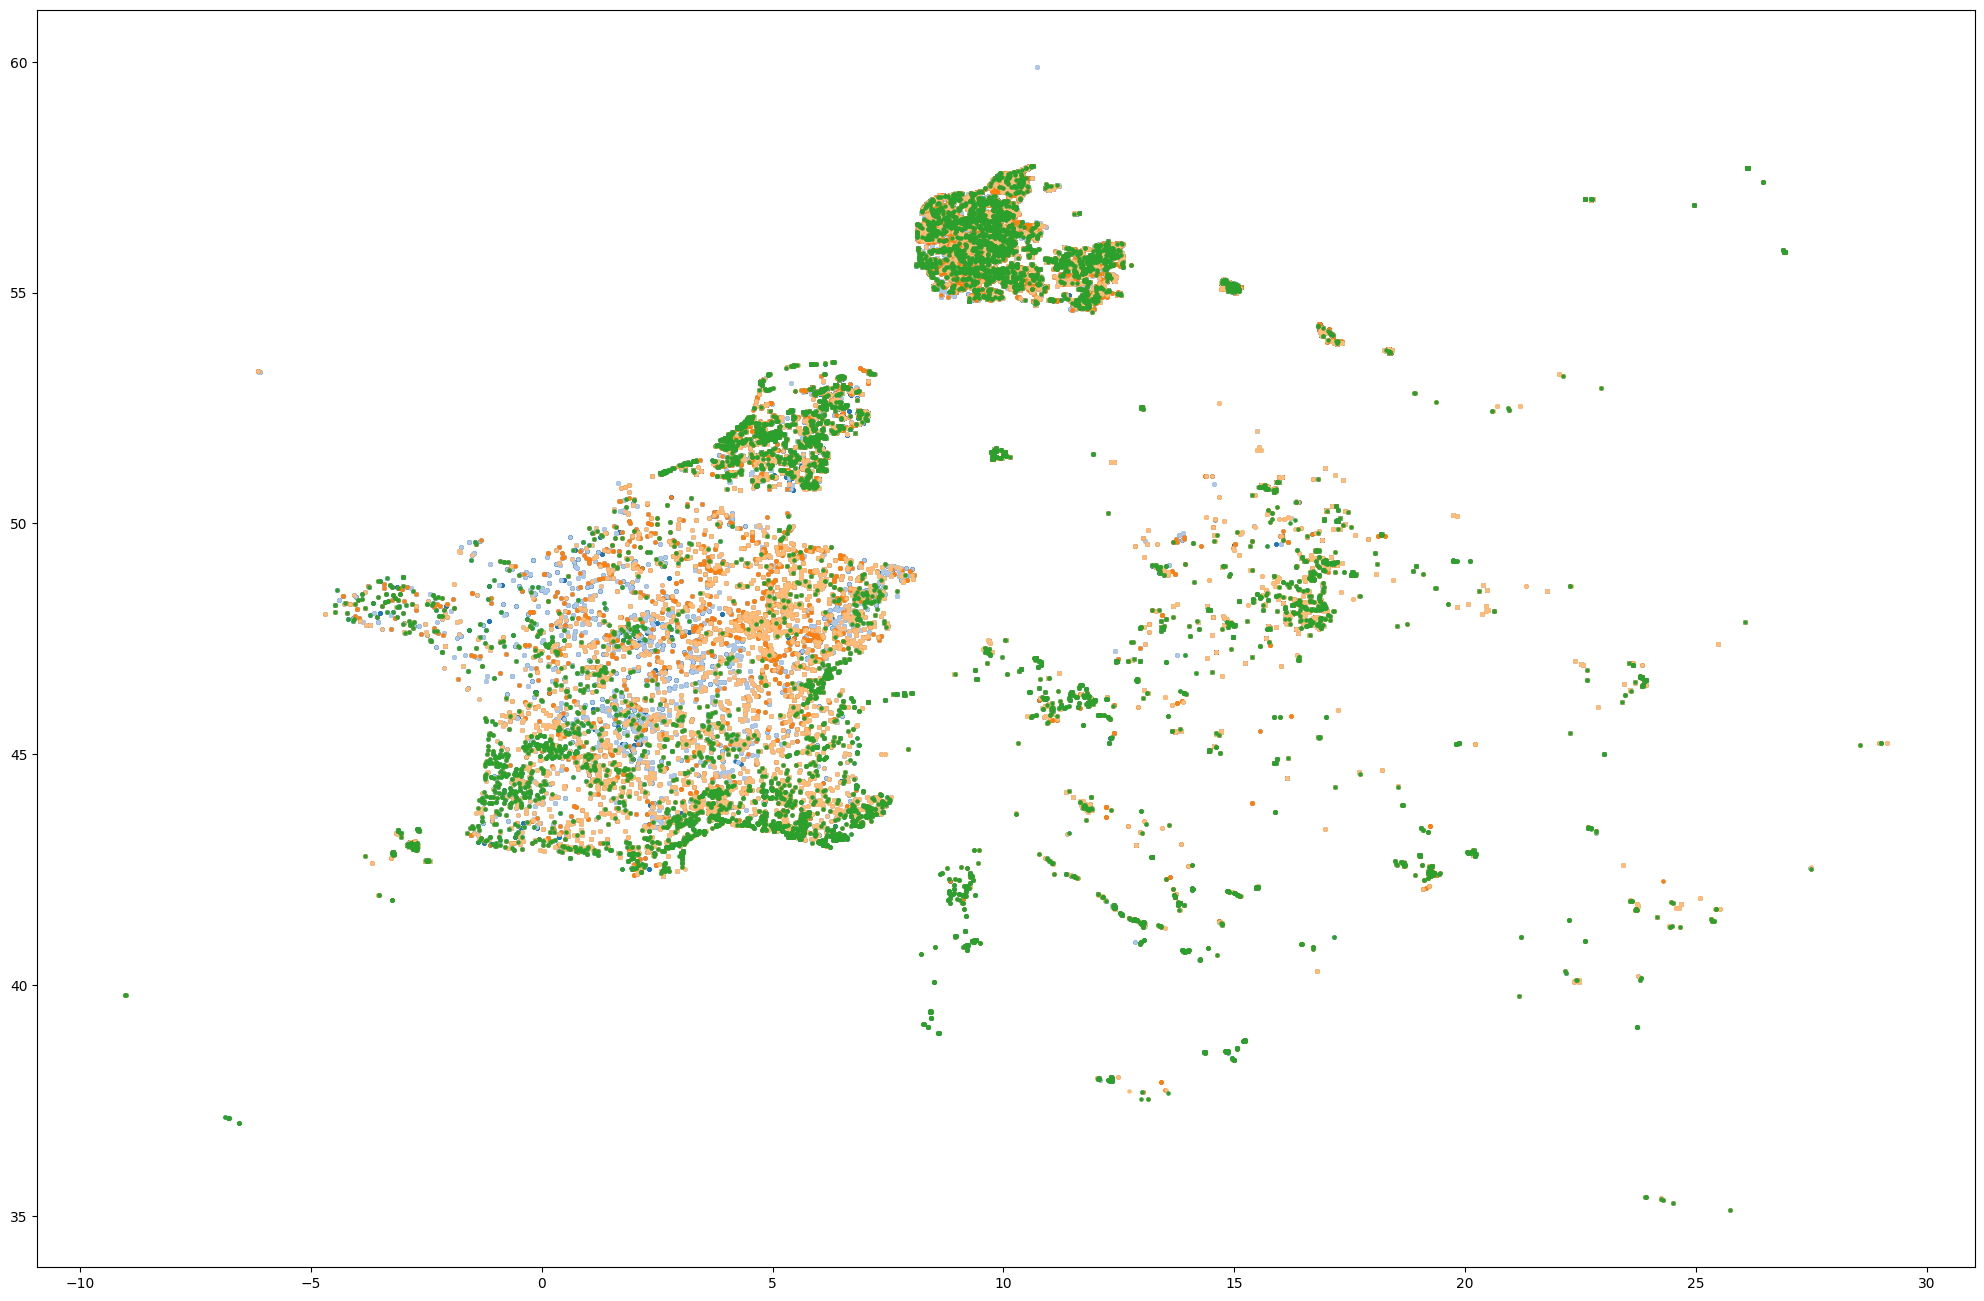

In [6]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Create a GeoDataFrame from the dataset
geometry = gpd.points_from_xy(df['lon'], df['lat'])
gdf = gpd.GeoDataFrame(df, geometry=geometry)

# Get unique species IDs and assign a unique color to each
unique_species = gdf['speciesId'].unique()
colors = cm.get_cmap('tab20', len(unique_species))  # Use a colormap with enough distinct colors

# Create a color mapping for species IDs
species_color_map = {species: colors(i) for i, species in enumerate(unique_species)}

# Assign colors to each point based on speciesId
gdf['color'] = gdf['speciesId'].map(species_color_map)

# Set up the plot
fig, ax = plt.subplots(figsize=(25, 20))

# Plot each species with its assigned color
for species in unique_species:
    species_data = gdf[gdf['speciesId'] == species]
    species_data.plot(
        ax=ax,
        marker='o',
        color=species_color_map[species],
        markersize=5,
        label=f'Species {species}'
    )

# Add a grid to the plot
ax.grid(True, linestyle='--', alpha=0.5)

# Customize the plot
plt.title("Tree Distribution by Species")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Species ID", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')  # Add a legend
plt.tight_layout()
plt.show()


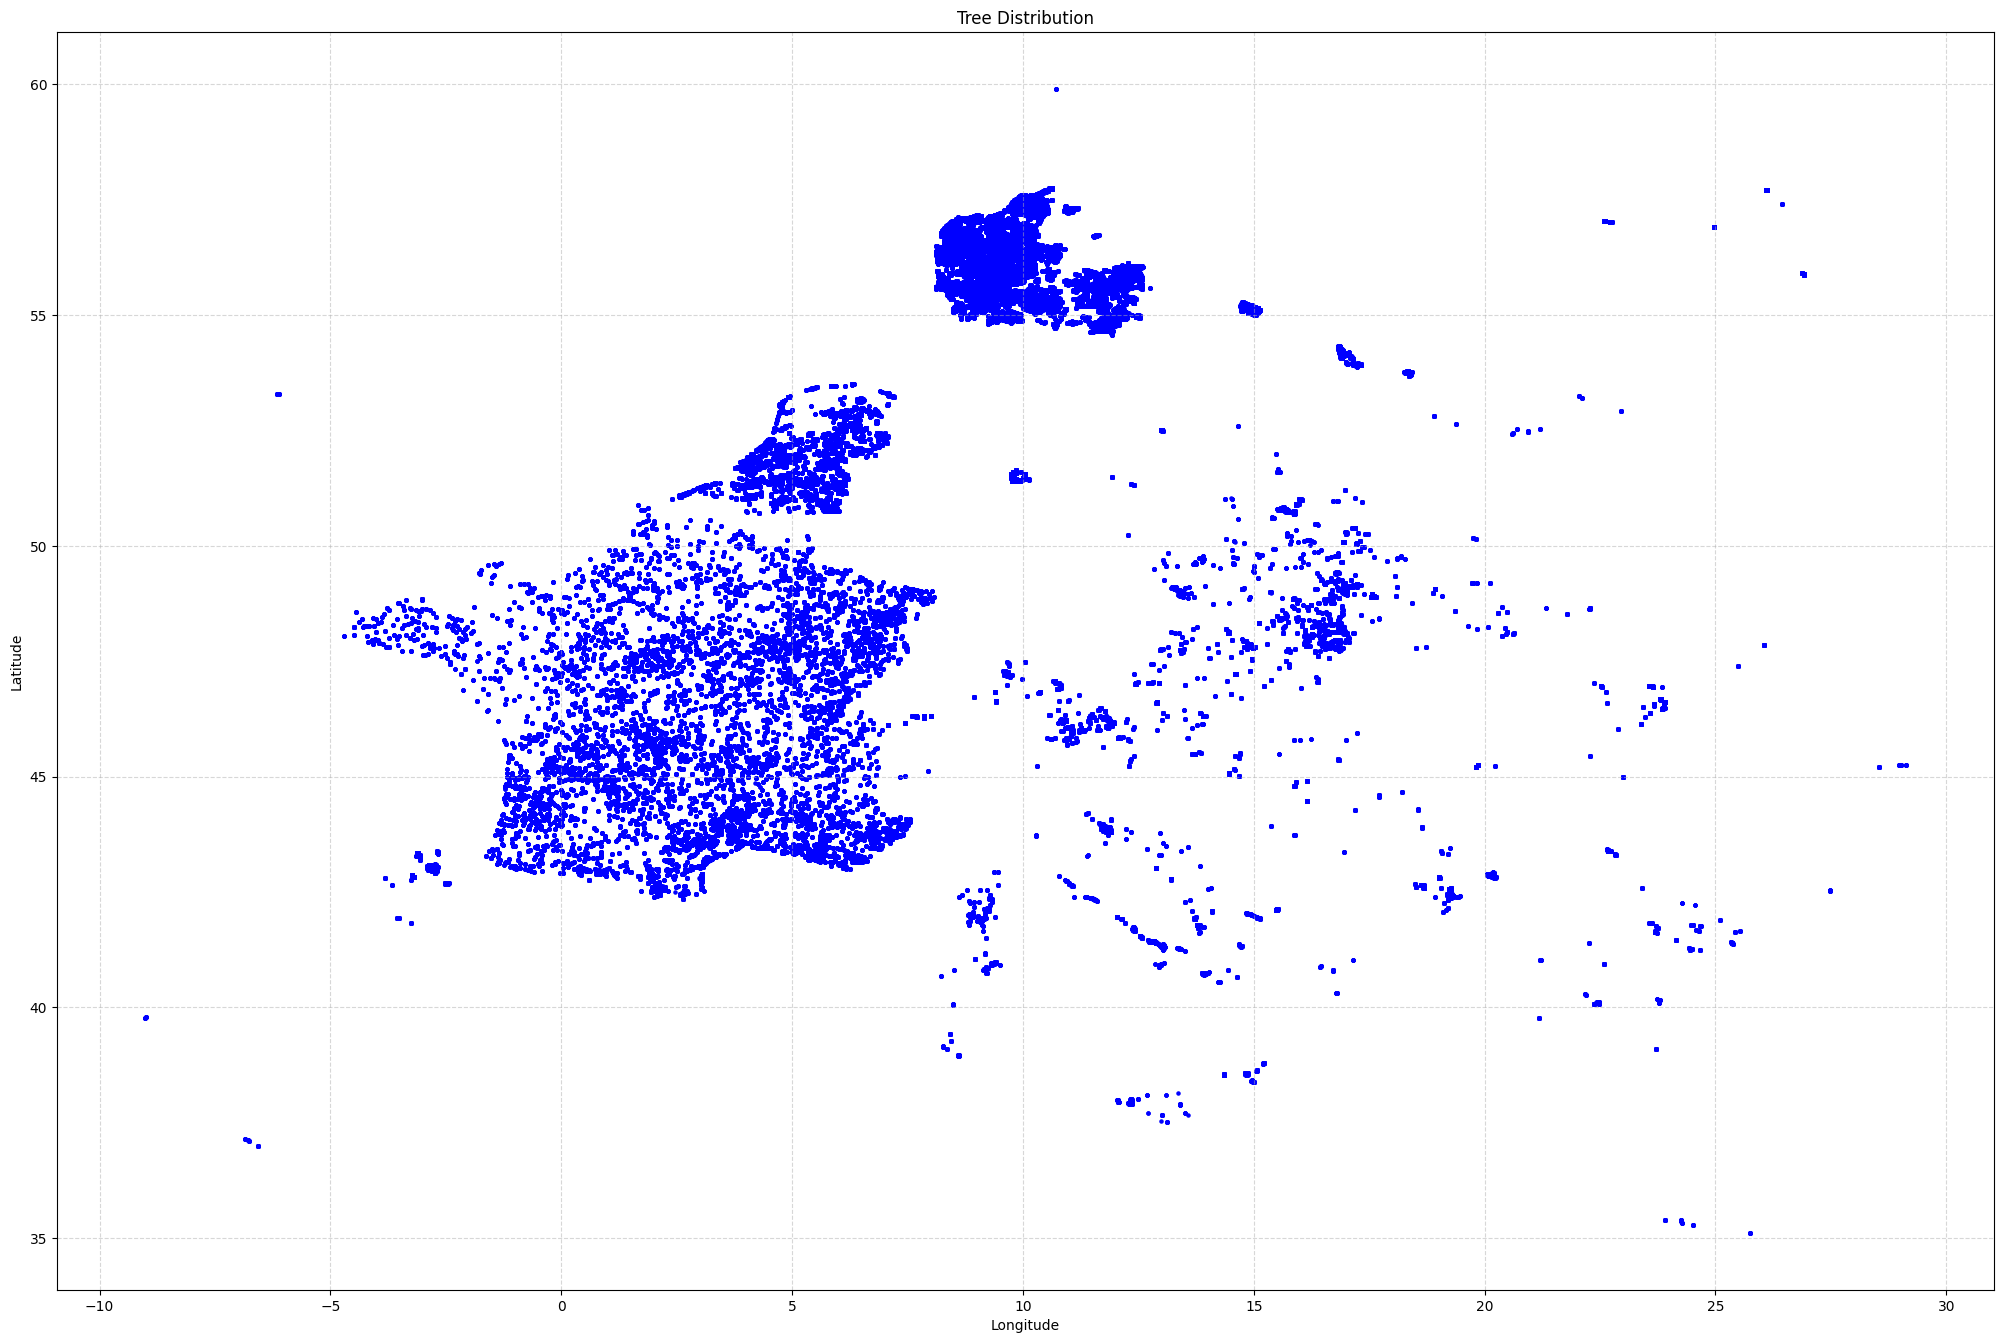

In [6]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Create a GeoDataFrame from the dataset
geometry = gpd.points_from_xy(df['lon'], df['lat'])
gdf = gpd.GeoDataFrame(df, geometry=geometry)

# Set up the plot
fig, ax = plt.subplots(figsize=(25, 20))

# Plot all points with a single marker
gdf.plot(ax=ax, marker='o', color='blue', markersize=5)  # Use 'o' marker in blue color

# Add a grid to the plot
ax.grid(True, linestyle='--', alpha=0.5)  # Customize grid style and transparency

# Customize the plot
plt.title("Tree Distribution")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [15]:
# Density-Based Spatial Clustering of Applications with Noise
from sklearn.cluster import DBSCAN
import pandas as pd

# Prepare the data for clustering
coordinates = df[['lon', 'lat']].values

# Apply DBSCAN
dbscan = DBSCAN(eps=0.013, min_samples=1)  # Adjust eps based on your data density
df['cluster'] = dbscan.fit_predict(coordinates)

# -1 indicates noise/outliers that weren't assigned to any cluster
# Group by clusters to see which species and survey IDs are in each cluster
clusters_info = df.groupby('cluster').agg({
    'speciesId': lambda x: list(x),  # List of species IDs in each cluster
    'surveyId': lambda x: list(x),  # Unique survey IDs in each cluster
    'lon': lambda x: list(x),  # List of longitudes for each species in the cluster
    'lat': lambda x: list(x)    # List of latitudes for each species in the cluster
}).reset_index()

# Rename columns for clarity and calculate average coordinates
clusters_info.rename(columns={'lon': 'coordinates_lon', 'lat': 'coordinates_lat'}, inplace=True)

# Add average coordinates for the cluster
clusters_info['average_lon'] = clusters_info['coordinates_lon'].apply(lambda x: sum(x) / len(x))
clusters_info['average_lat'] = clusters_info['coordinates_lat'].apply(lambda x: sum(x) / len(x))

# Print cluster information
print(clusters_info)

# Count number of clusters, excluding noise (-1)
num_clusters = len(set(df['cluster'])) - (1 if -1 in df['cluster'] else 0)
print(f"Number of clusters: {num_clusters}")

       cluster                                          speciesId  \
0            0  [6874.0, 476.0, 11157.0, 8784.0, 4530.0, 10520...   
1            1  [9816.0, 540.0, 4499.0, 433.0, 254.0, 6750.0, ...   
2            2  [5386.0, 3227.0, 6079.0, 254.0, 6964.0, 1387.0...   
3            3     [9028.0, 2386.0, 694.0, 9388.0, 146.0, 6788.0]   
4            4  [2474.0, 981.0, 3935.0, 8151.0, 10247.0, 5189....   
...        ...                                                ...   
10795    10795    [10247.0, 981.0, 8613.0, 2885.0, 963.0, 4871.0]   
10796    10796  [10247.0, 7942.0, 1694.0, 8208.0, 10909.0, 221...   
10797    10797  [3457.0, 7536.0, 2474.0, 9647.0, 7862.0, 10909...   
10798    10798  [8138.0, 10315.0, 904.0, 8208.0, 7113.0, 1768....   
10799    10799                            [1539.0, 963.0, 4609.0]   

                                                surveyId  \
0                                                [212.0]   
1      [222.0, 8422.0, 55746.0, 60882.0, 65601.0, 6

In [18]:
print(clusters_info.columns)

Index(['cluster', 'speciesId', 'surveyId', 'coordinates_lon',
       'coordinates_lat', 'average_lon', 'average_lat'],
      dtype='object')


In [19]:
from sklearn.metrics import silhouette_score

# Take a random sample of your DataFrame if it's too large
sample_size = 1000  # Adjust as needed
df_sampled = df.sample(n=sample_size, random_state=4)  # Use a random seed for reproducibility

# Compute silhouette score on the sampled data
if -1 in df_sampled['cluster'].values:
    valid_clusters = df_sampled[df_sampled['cluster'] != -1]
else:
    valid_clusters = df_sampled

silhouette_avg = silhouette_score(valid_clusters[['lon', 'lat']], valid_clusters['cluster'])
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.26172955366564976


In [17]:
# Save cluster information to a CSV file
clusters_info.to_csv('clusters_info.csv', index=False)

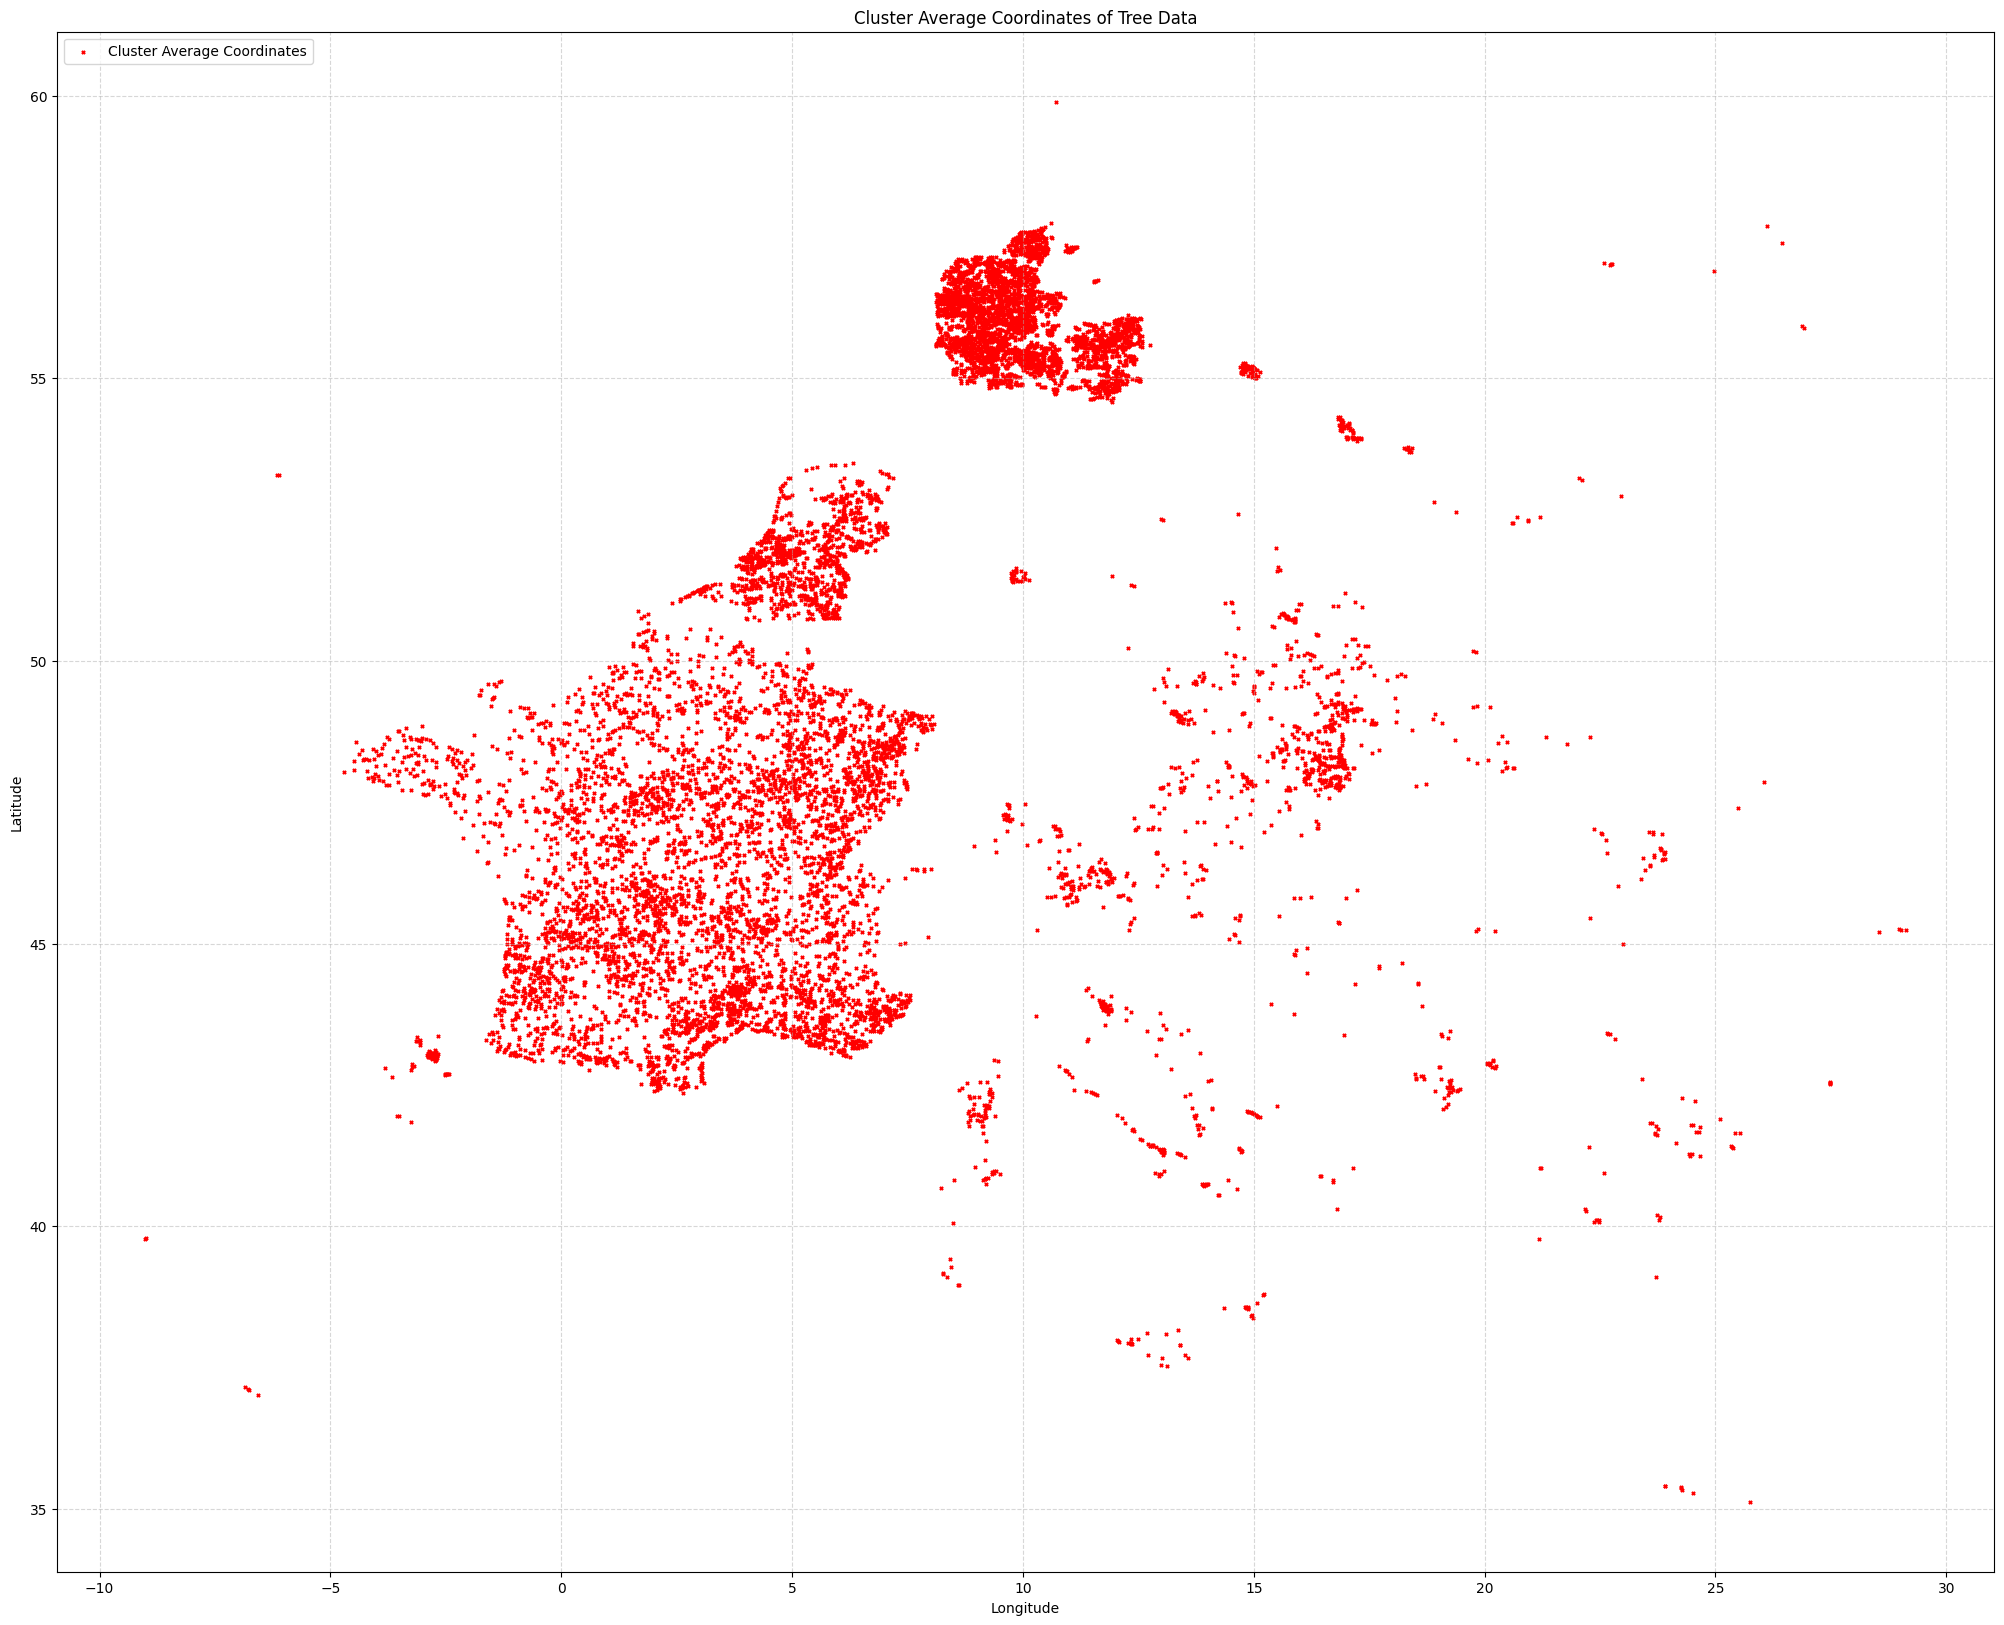

In [20]:
import matplotlib.pyplot as plt

# Set up the plot
fig, ax = plt.subplots(figsize=(25, 20))

# Plot the cluster average coordinates
ax.scatter(clusters_info['average_lon'], clusters_info['average_lat'], 
           c='red', marker='x', s=5, label='Cluster Average Coordinates')  # 'X' marker for average coordinates

# Customize the plot
plt.title("Cluster Average Coordinates of Tree Data")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(loc="upper left")
plt.grid(True, linestyle='--', alpha=0.5)  # Add a grid for reference

# Show the plot
plt.show()

In [11]:
# import geopandas as gpd
# import matplotlib.pyplot as plt
# from sklearn.cluster import DBSCAN
# from scipy.spatial import ConvexHull
# import numpy as np

# # Assuming df is your DataFrame containing 'lon', 'lat', and 'speciesId'
# # Prepare the data for clustering
# coordinates = df[['lon', 'lat']].values

# # Apply DBSCAN
# dbscan = DBSCAN(eps=0.005, min_samples=5)  # Adjust eps based on your data density
# df['cluster'] = dbscan.fit_predict(coordinates)

# # Create a GeoDataFrame from the dataset
# geometry = gpd.points_from_xy(df['lon'], df['lat'])
# gdf = gpd.GeoDataFrame(df, geometry=geometry)

# # Set up the plot
# fig, ax = plt.subplots(figsize=(15, 10))

# # Plot all points with a single marker
# gdf.plot(ax=ax, marker='o', color='blue', markersize=5, label='Trees')  # Use 'o' marker in blue color

# # Plot cluster boundaries
# for cluster_id in gdf['cluster'].unique():
#     if cluster_id != -1:  # Skip noise points
#         cluster_points = gdf[gdf['cluster'] == cluster_id]
#         if len(cluster_points) >= 3:  # Need at least three points to form a convex hull
#             hull = ConvexHull(cluster_points[['lon', 'lat']].values)
#             hull_points = np.append(hull.vertices, hull.vertices[0])  # Close the polygon
#             ax.plot(cluster_points.iloc[hull_points]['lon'], 
#                     cluster_points.iloc[hull_points]['lat'], 
#                     color='red', alpha=0.5)  # Draw the boundary in red

# # Add a grid to the plot
# ax.grid(True, linestyle='--', alpha=0.5)  # Customize grid style and transparency

# # Customize the plot
# plt.title("Tree Distribution with Cluster Boundaries")
# plt.xlabel("Longitude")
# plt.ylabel("Latitude")
# plt.legend()
# plt.show()

In [12]:
# import requests

# # OpenWeatherMap API credentials
# api_key = "00e8e808c9ee63e1a6848d838daabe6d"

# # Function to get all air pollution components from OpenWeatherMap for given lat and lon
# def get_air_pollution_data(lat, lon):
#         url = f"http://api.openweathermap.org/data/2.5/air_pollution?lat={lat}&lon={lon}&appid={api_key}"
        
#         # Make the API request
#         response = requests.get(url)
        
#         if response.status_code == 200:
#             data = response.json()  # Parse the response to JSON
#             main_aqi = data['list'][0]['main']['aqi']  # AQI value
            
#             components = data['list'][0]['components']  # All pollutant components
#             co2 = components.get('co2', None)
#             co = components.get('co', None)       # Carbon Monoxide
#             no = components.get('no', None)       # Nitric Oxide
#             no2 = components.get('no2', None)     # Nitrogen Dioxide
#             o3 = components.get('o3', None)       # Ozone
#             so2 = components.get('so2', None)     # Sulfur Dioxide
#             pm25 = components.get('pm2_5', None)  # Fine Particulate Matter (PM2.5)
#             pm10 = components.get('pm10', None)   # Coarse Particulate Matter (PM10)
#             nh3 = components.get('nh3', None)     # Ammonia

#             return main_aqi, co2, co, no, no2, o3, so2, pm25, pm10, nh3
        
#         else:
#             return [None] * 9  # Return None for all fields if the request fails

#     # Applying the function to each row in the dataset
#     df[['AQI', 'CO2', 'CO', 'NO', 'NO2', 'O3', 'SO2', 'PM2.5', 'PM10', 'NH3']] = pd.DataFrame(
#         df.apply(lambda row: get_air_pollution_data(row['latitude_coordinate'], row['longitude_coordinate']), axis=1).tolist()
#     )

#     # units of all data is µg/m³

In [22]:
import requests

# OpenWeatherMap API credentials
api_key = "00e8e808c9ee63e1a6848d838daabe6d"

# Function to get all air pollution components from OpenWeatherMap for given lat and lon
def get_air_pollution_data(lat, lon):
    url = f"http://api.openweathermap.org/data/2.5/air_pollution?lat={lat}&lon={lon}&appid={api_key}"
    
    # Make the API request
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raises an error for 4XX/5XX responses
        data = response.json()  # Parse the response to JSON
        main_aqi = data['list'][0]['main']['aqi']  # AQI value
        
        components = data['list'][0]['components']  # All pollutant components
        co2 = components.get('co2', None)
        co = components.get('co', None)       # Carbon Monoxide
        no = components.get('no', None)       # Nitric Oxide
        no2 = components.get('no2', None)     # Nitrogen Dioxide
        o3 = components.get('o3', None)       # Ozone
        so2 = components.get('so2', None)     # Sulfur Dioxide
        pm25 = components.get('pm2_5', None)  # Fine Particulate Matter (PM2.5)
        pm10 = components.get('pm10', None)   # Coarse Particulate Matter (PM10)
        nh3 = components.get('nh3', None)     # Ammonia

        return main_aqi, co2, co, no, no2, o3, so2, pm25, pm10, nh3
    except Exception as e:
        print(f"Error retrieving data for lat: {lat}, lon: {lon}. Error: {e}")
        return [None] * 10  # Return None for all fields if the request fails

# Fetch data in chunks
batch_size = 100  # Adjust the batch size as needed
results = []

for start in range(0, len(clusters_info), batch_size):
    clusters_info_subset = clusters_info.iloc[start:start + batch_size]  # Get the current batch
    batch_results = pd.DataFrame(clusters_info_subset.apply(
        lambda row: get_air_pollution_data(row['average_lat'], row['average_lon']), axis=1).tolist(),
        columns=['AQI', 'CO2', 'CO', 'NO', 'NO2', 'O3', 'SO2', 'PM2.5', 'PM10', 'NH3'
    ])
    
    # Append results to the main results list
    results.append(batch_results)

    # Save the current batch to a CSV to avoid data loss
    batch_results.to_csv('air_pollution_data.csv', mode='a', header=False, index=False)

# Concatenate all results into a final DataFrame
final_results = pd.concat(results, ignore_index=True)

# Display the final DataFrame with air pollution data
print(final_results)

       AQI   CO2      CO   NO    NO2     O3    SO2  PM2.5   PM10   NH3
0        3  None  373.84  0.0   9.25  33.62   0.89  32.71  36.30  0.70
1        2  None  226.97  0.0   1.30  73.67   0.27   0.67   2.17  1.54
2        2  None  223.64  0.0   0.58  86.55   0.28   0.54   2.21  0.60
3        2  None  233.65  0.0   4.16  32.54   0.23  12.78  14.86  0.86
4        1  None  226.97  0.0   1.99  44.35   0.12   6.22   9.25  0.59
...    ...   ...     ...  ...    ...    ...    ...    ...    ...   ...
10795    1  None  223.64  0.0   5.01  36.48   0.45   2.40   2.98  0.99
10796    1  None  226.97  0.0   1.84  40.05   0.09   6.70   9.91  0.59
10797    1  None  223.64  0.0   3.30  30.76   0.13   6.76   7.36  0.69
10798    2  None  213.62  0.0   1.99  59.37  11.44  23.09  23.47  0.09
10799    2  None  277.04  0.0  15.42  15.74   2.12  12.97  14.25  0.33

[10800 rows x 10 columns]


In [23]:
# Load your data
clusters_info = pd.read_csv('clusters_info.csv')
air_pollution_data = pd.read_csv('air_pollution_data.csv')

# Reset index to ensure alignment for concatenation
clusters_info.reset_index(drop=True, inplace=True)
air_pollution_data.reset_index(drop=True, inplace=True)

# Concatenate the DataFrames side by side (axis=1)
merged_data = pd.concat([clusters_info, air_pollution_data], axis=1)

# Display the merged DataFrame
print(merged_data)

# Save the merged data to a new CSV file
merged_data.to_csv('cluster_with_pollution_data.csv', index=False)

       cluster                                          speciesId  \
0            0  [6874.0, 476.0, 11157.0, 8784.0, 4530.0, 10520...   
1            1  [9816.0, 540.0, 4499.0, 433.0, 254.0, 6750.0, ...   
2            2  [5386.0, 3227.0, 6079.0, 254.0, 6964.0, 1387.0...   
3            3     [9028.0, 2386.0, 694.0, 9388.0, 146.0, 6788.0]   
4            4  [2474.0, 981.0, 3935.0, 8151.0, 10247.0, 5189....   
...        ...                                                ...   
10795    10795    [10247.0, 981.0, 8613.0, 2885.0, 963.0, 4871.0]   
10796    10796  [10247.0, 7942.0, 1694.0, 8208.0, 10909.0, 221...   
10797    10797  [3457.0, 7536.0, 2474.0, 9647.0, 7862.0, 10909...   
10798    10798  [8138.0, 10315.0, 904.0, 8208.0, 7113.0, 1768....   
10799    10799                            [1539.0, 963.0, 4609.0]   

                                                surveyId  \
0                                    [np.float64(212.0)]   
1      [np.float64(222.0), np.float64(8422.0), np.f